# Trajectory reconstruction from  synthetic scRNA-Seq data of the star network

We analyse the synthetic scRNA-Seq data generated by scBoolSeq from the Boolean simulations of the star network in [2.1 - synthetic scRNA-Seq from star network.ipynb](2.1%20-%20synthetic%20scRNA-Seq%20from%20star%20network.ipynb).

⚠️ This notebook must be run in a STREAM environment

In [1]:
import stream as st
st.__version__

/opt/conda/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


'1.0'

In [2]:
st.set_figure_params(dpi=80,style='white',figsize=[5.4,4.8],
                     rc={'image.cmap': 'viridis'})

#### Read in data

In [3]:
adata=st.read(file_name='synthetic_data_star_counts.tsv',workdir='./stream_result')

Saving results in: ./stream_result


In [4]:
adata

AnnData object with n_obs × n_vars = 3300 × 11 
    uns: 'workdir'

#### Read in metadata

In [4]:
st.add_metadata(adata,file_name='synthetic_data_star_metadata.tsv')

In [5]:
adata.obs.head()

,label,label_color
step0_0,0,#A2F37E
step1_0,1,#36873F
step2_0,2,#81D278
step3_0,3,#8CA2D4
step4_0,4,#D0327B


#### Calculate QC

In [6]:
st.cal_qc(adata,assay='rna')

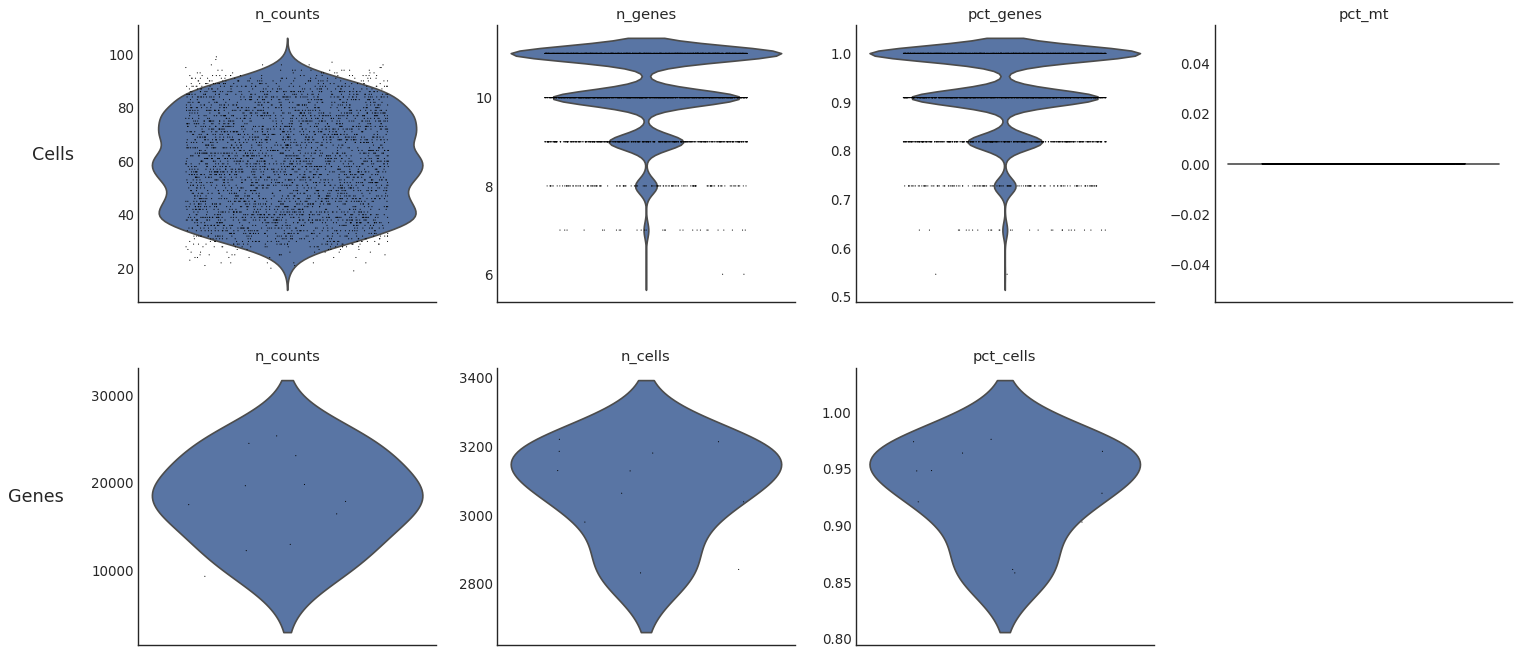

In [7]:
st.plot_qc(adata,jitter=0.3,)

Commented the following code section because no cells survived the filtering.

In [8]:
st.filter_cells(adata,min_n_features= 11)
st.filter_features(adata,min_n_cells = 500)

filter cells based on min_n_features
after filtering out low-quality cells: 
1595 cells, 11 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
1595 cells, 11 genes


#### Feature selection

Please check if the blue curve fits the points well. If not, please adjust the parameter **'loess_frac'** (usually by lowering it) until the blue curve fits well. 

9 variable genes are selected


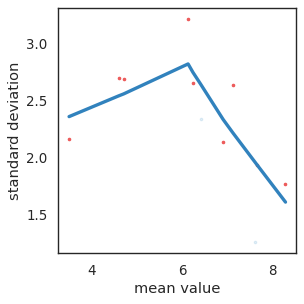

In [9]:
st.select_variable_genes(adata,loess_frac=0.9,percentile=15)

**Alternatively, user can also select top  principal components using all genes or variable genes:**
- use all genes   
`st.select_top_principal_components(adata,n_pc=15,first_pc=True)`
- use variable genes   
    - users need to first run `st.select_variable_genes(adata,loess_frac=0.01, n_genes=2000)`  
    - `st.select_top_principal_components(adata,feature='var_genes',n_pc=40,first_pc=True)`

#### Dimension reduction

In [10]:
st.dimension_reduction(adata,method='se',feature='var_genes',n_components=2,n_neighbors=15,n_jobs=4)

feature var_genes is being used ...
4 cpus are being used ...


> **Alternatively, using top principal components as features:**
`st.dimension_reduction(adata,method='se',feature='top_pcs',n_neighbors=15, n_components=2)`

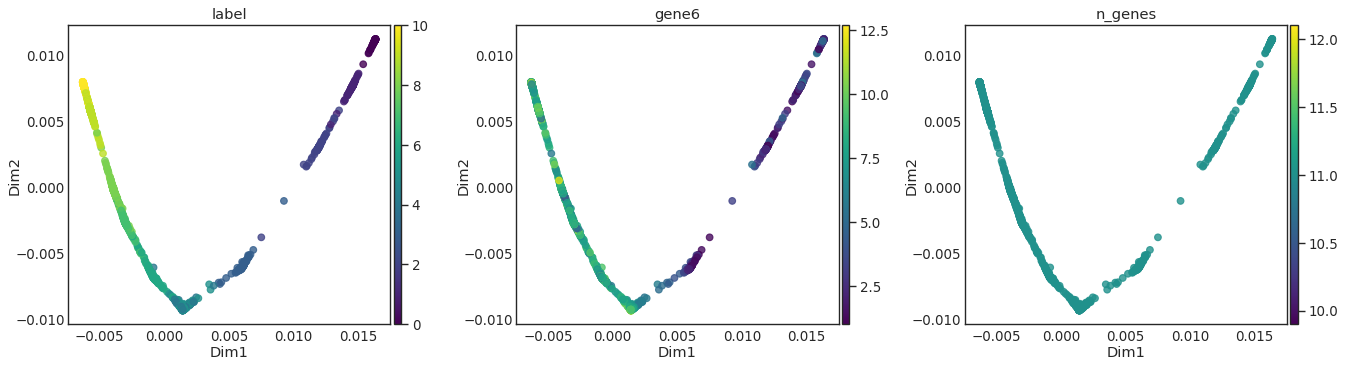

In [11]:
st.plot_dimension_reduction(adata,color=['label','gene6','n_genes'],
                            n_components=2,show_graph=False,show_text=False)

#### Trajectory inference

In [12]:
st.seed_elastic_principal_graph(adata,n_clusters=10)

Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 1


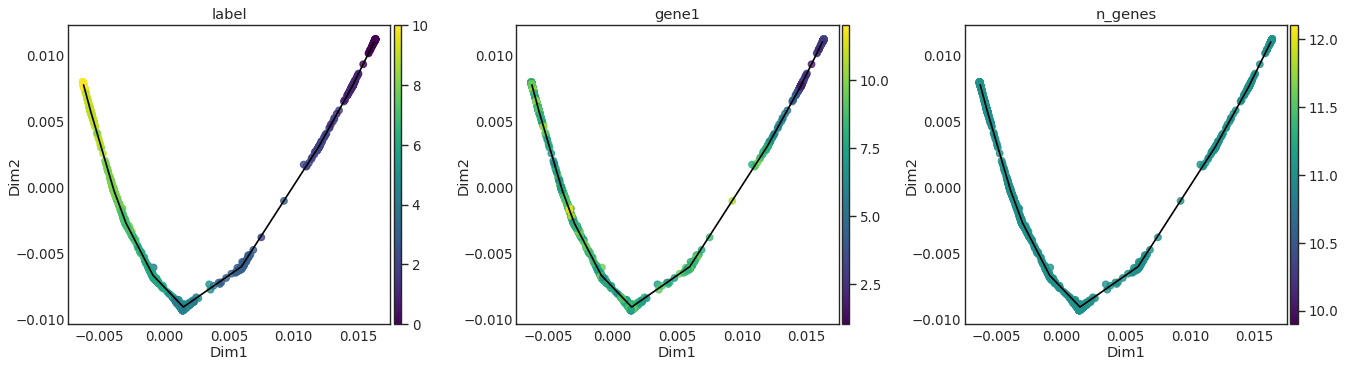

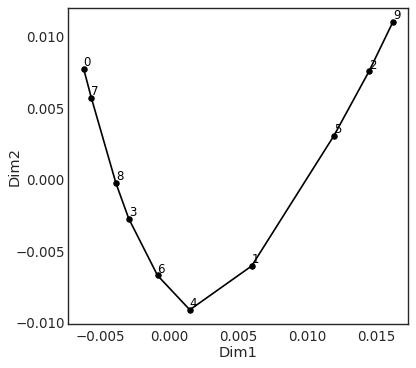

In [13]:
st.plot_dimension_reduction(adata,color=['label','gene1','n_genes'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=True)

**`epg_alpha`, `epg_mu`, `epg_lambda` are the three most influential parameters for learning elastic principal graph.**  
- `epg_alpha`: penalizes spurious branching events. **The larger, the fewer branches the function will learn**. (by default, `epg_alpha=0.02`)
- `epg_mu`: penalizes the deviation from harmonic embedding, where harmonicity assumes that each node is the mean of its neighbor nodes. **The larger, the more edges the function will use to fit into points(cells)** (by default, `epg_mu=0.1`) 
- `epg_lambda`: penalizes the total length of edges. **The larger, the 'shorter' curves the function will use to fit into points(cells)** and the fewer points(cells) the curves will reach. (by default, `epg_lambda=0.02`)

> **'epg_trimmingradius'** can help get rid of noisy points (by defalut `epg_trimmingradius=Inf`)   
e.g. `st.elastic_principal_graph(adata,epg_trimmingradius=0.1)`  

In [14]:
st.elastic_principal_graph(adata,epg_alpha=0.1,epg_mu=0.05,epg_lambda=0.05)

Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 1595 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||50
	
2.096e-06
	
50
	
49
	
48
	
0
	
0
	
0
	
1.892e-07
	
1.502e-07
	
0.9979
	
0.9983
	
1.836e-06
	
7.072e-08
	
3.536e-06
	
0.0001768
	
0


12.379 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 1


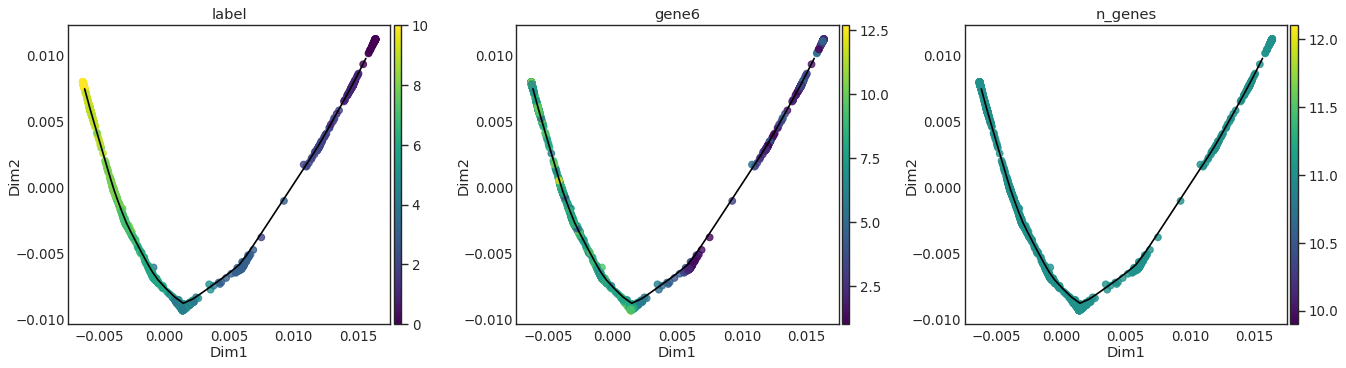

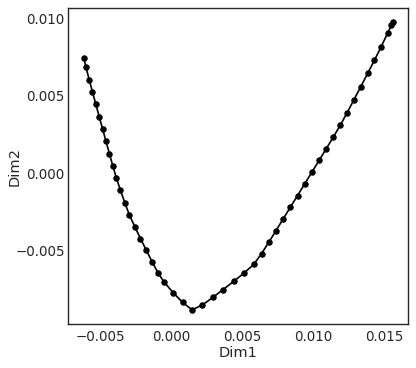

In [15]:
st.plot_dimension_reduction(adata,color=['label','gene6','n_genes'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=False)

#### Adjusting trajectories (optional)

* Finetune branching event:  
```python
st.optimize_branching(adata,incr_n_nodes=30)
st.plot_dimension_reduction(adata,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=False)
```
* Prune trivial branches:  
```python
st.prune_elastic_principal_graph(adata,epg_collapse_mode='EdgesNumber',epg_collapse_par=2)
st.plot_dimension_reduction(adata,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=False)
```

* Shift branching node:  
```python
st.shift_branching(adata,epg_shift_mode='NodeDensity',epg_shift_radius=0.1,epg_shift_max=3)
st.plot_dimension_reduction(adata,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=False)
```

Extending leaves with additional nodes ...
Number of branches after extending leaves: 1


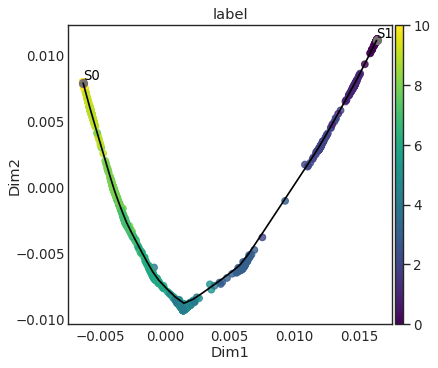

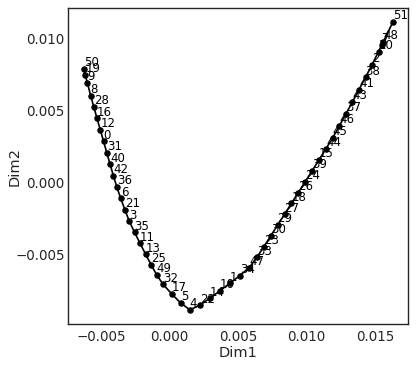

In [16]:
###Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
st.plot_dimension_reduction(adata,color=['label'],n_components=2,show_graph=True,show_text=True)
st.plot_branches(adata,show_text=True)

#### Trajectory visualization

##### flat tree

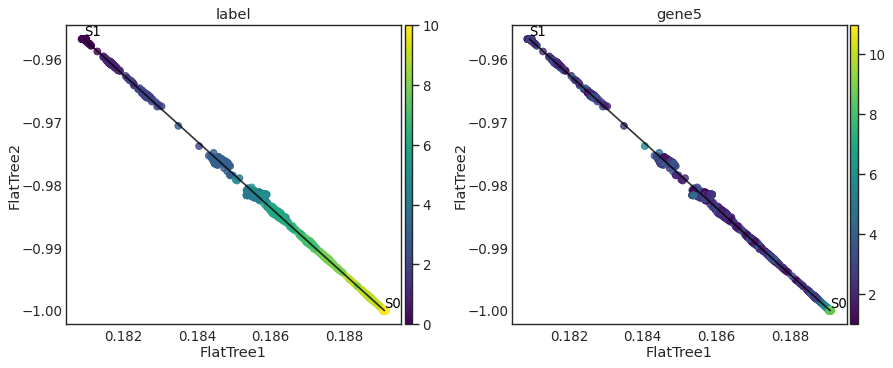

In [17]:
st.plot_flat_tree(adata,color=['label', 'gene5'],#, 'S0_pseudotime'],
                  dist_scale=0.5,show_graph=True,show_text=True)

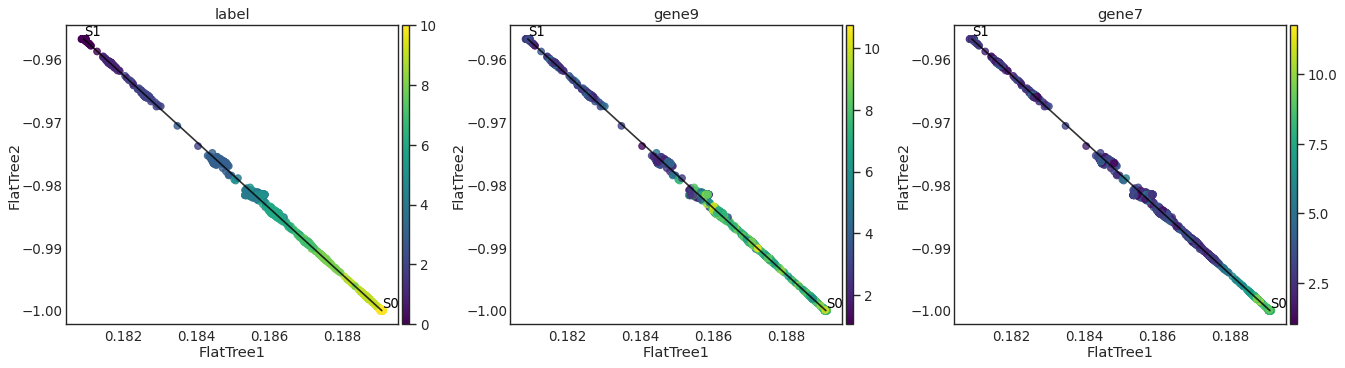

In [18]:
st.plot_flat_tree(adata,color=['label', 'gene9','gene7'],
                  dist_scale=0.5,show_graph=True,show_text=True)

##### stream plot at single cell level

In [19]:
root = "S1"

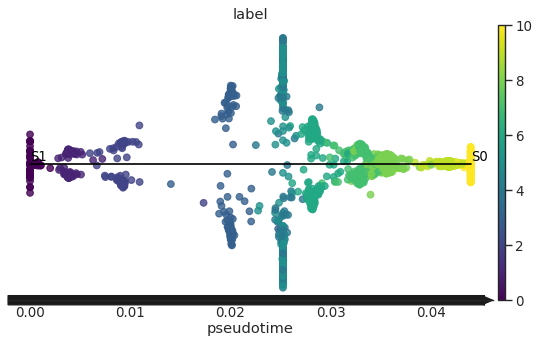

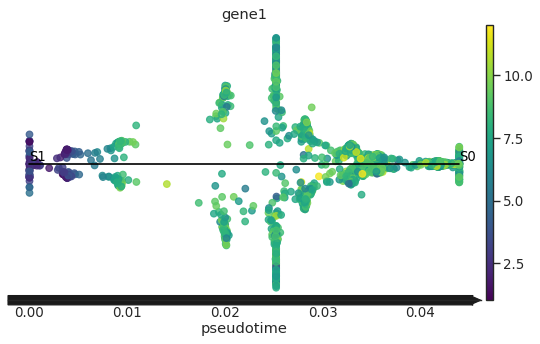

In [20]:
st.plot_stream_sc(adata,root=root,color=['label','gene1'],
                  dist_scale=0.3,show_graph=True,show_text=True)

##### stream plots

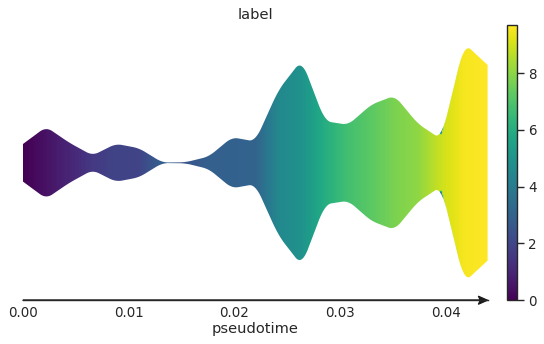

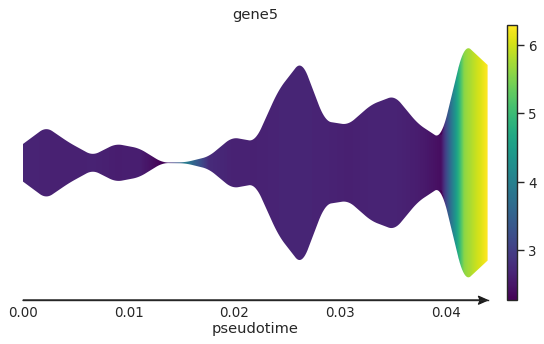

In [21]:
st.plot_stream(adata,root=root,color=['label','gene5'])

**Some useful parameters to finetune the appearance of stream plots:**
* `dist_scale`: controls the width of STREAM plot branches.
* `factor_num_win`: controls the resolution of STREAM plot.
* `preference`: controls the order of branches
* `log_scale`: shows stream plot in log scale to zoom in on thin branches